In [3]:
'''
This file is for examining the relationship between training images for each taxa and their F1 scores.
Includes bubble graphs with regression.
'''

import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from scipy.stats import norm
from scipy import stats

In [4]:
#import the data

regions = ['Gulf', 'PA', 'NL 2020', 'NL 2021']
path = 'CyrilUnzipped/AMP FlowCam strategy predictions results and reports'

#max_class_size = 'Max Objects'
max_class_size = '5000'

# this function retrieves particular spreadsheets corresponding to prediction strategy results from Cyril's folders and combines the specified sheets into one dataframe
# note that scn is false by default since SCN was found to be detrimental. Pass scn=True as an argument if SCN is preferred
def combine_specified_sheets(path, image_num, sheet_string, scn=False):
    four_sheets = []
    for region in regions:
        for name in glob.glob(path + '/' + region + '/metrics/*'):
            scn_string = 'Without SCN-'
            if scn:
                scn_string = 'With SCN-'
            if scn_string + image_num in name:
                print(name)
                xls = pd.ExcelFile(name)
                sheet_names = xls.sheet_names
                for sheet_name in sheet_names:
                    if sheet_string in sheet_name:
                        current_sheet = pd.read_excel(xls, sheet_name)
                        four_sheets.append(current_sheet)
    return four_sheets

four_sheets = combine_specified_sheets(path, max_class_size, 'strategy#4')
for i, sheet in enumerate(four_sheets):
    four_sheets[i]['regionYear'] = regions[i]
f1_df = pd.concat(four_sheets).reset_index(drop=True) # combine the four sheets into one

CyrilUnzipped/AMP FlowCam strategy predictions results and reports/Gulf/metrics\Gulf-Without SCN-5000 Objects-metrics data.xlsx
CyrilUnzipped/AMP FlowCam strategy predictions results and reports/PA/metrics\PA-Without SCN-5000 Objects-metrics data.xlsx
CyrilUnzipped/AMP FlowCam strategy predictions results and reports/NL 2020/metrics\NL 2020-Without SCN-5000 Objects-metrics data.xlsx
CyrilUnzipped/AMP FlowCam strategy predictions results and reports/NL 2021/metrics\NL 2021-Without SCN-5000 Objects-metrics data.xlsx


In [5]:
#rename the taxa name column and remove the summary rows from the bottom of each dataframe
f1_df = f1_df.rename(columns = {"Unnamed: 0": "newName"})
f1_df = f1_df[f1_df['newName'] != 'macro avg (corr)']
f1_df = f1_df[f1_df['newName'] != 'weighted avg']
f1_df

,newName,precision,recall,f1-score,support,regionYear
0,Acartia spp.,0.991436,0.435832,0.605492,18062,Gulf
1,Bivalvia (larvae),0.972435,0.926838,0.949089,7955,Gulf
2,Copepoda (nauplii),0.799618,0.913186,0.852637,2753,Gulf
3,Podon/Pleopsis spp.,0.867176,0.668508,0.754992,2715,Gulf
4,Oithona spp.,0.269162,0.824650,0.405855,2572,Gulf
...,...,...,...,...,...,...
106,Cirripedia (larvae),0.000000,0.000000,0.000000,0,NL 2021
107,Copepoda (nauplii),0.000000,0.000000,0.000000,0,NL 2021
108,Obelia spp. (medusa),0.000000,0.000000,0.000000,0,NL 2021
109,Euphausiacea (larvae),0.000000,0.000000,0.000000,0,NL 2021


In [6]:
#checking the number of taxa with F1 scores for each region to see that they make sense.
for regionYear in regions:
    print(regionYear)
    print(len(f1_df[f1_df['regionYear'] == regionYear]['newName'].unique()))

Gulf
29
PA
26
NL 2020
25
NL 2021
25


In [7]:
#importing training data. This has the number of training images (regional and all_regions) used in each dataset.
training_sheets = []
name = 'regional_prediction_strategies.xlsx'
xls = pd.ExcelFile(name)
sheet_names = xls.sheet_names
print(sheet_names)
excluded_sheet = 'strategies'
for i, sheet_name in enumerate(sheet_names):
    if excluded_sheet not in sheet_name:
        current_sheet = pd.read_excel(xls, sheet_name)
        training_sheets.append(current_sheet)
for i, name in enumerate(sheet_names[1:]):
    training_sheets[i]['regionYear'] = name
    training_sheets[i] = training_sheets[i][['newName', 'region_training_classes_count', 'all_regions_training_classes_count', 'regionYear']]
training_df = pd.concat(training_sheets).reset_index(drop=True)
training_df

['strategies', 'Gulf', 'NL 2020', 'NL 2021', 'PA']


,newName,region_training_classes_count,all_regions_training_classes_count,regionYear
0,Acartia spp.,101461.0,111319,Gulf
1,Aglantha spp. (medusa),1.0,22,Gulf
2,Amphipoda,26.0,27,Gulf
3,Anthoathecata (medusa),NaN,0,Gulf
4,Ascidiacea (larvae),805.0,861,Gulf
...,...,...,...,...
259,Mysida (larvae),6.0,6,PA
260,Mysidacea,NaN,3,PA
261,Neoturris spp. (medusa),1.0,1,PA
262,Platyhelminthes/Nemertea (larvae),145.0,183,PA


In [8]:
# add regional training images counts to the dataframe with F1 scores
for i, row in f1_df.iterrows():
    for j, rowj in training_df.iterrows():
        if row['newName'] == rowj['newName'] and row['regionYear'] == rowj['regionYear']:
            f1_df.loc[i, 'regional_training'] = rowj['region_training_classes_count']
f1_df

,newName,precision,recall,f1-score,support,regionYear,regional_training
0,Acartia spp.,0.991436,0.435832,0.605492,18062,Gulf,101461.0
1,Bivalvia (larvae),0.972435,0.926838,0.949089,7955,Gulf,3574.0
2,Copepoda (nauplii),0.799618,0.913186,0.852637,2753,Gulf,10297.0
3,Podon/Pleopsis spp.,0.867176,0.668508,0.754992,2715,Gulf,3541.0
4,Oithona spp.,0.269162,0.824650,0.405855,2572,Gulf,4428.0
...,...,...,...,...,...,...,...
106,Cirripedia (larvae),0.000000,0.000000,0.000000,0,NL 2021,611.0
107,Copepoda (nauplii),0.000000,0.000000,0.000000,0,NL 2021,1025.0
108,Obelia spp. (medusa),0.000000,0.000000,0.000000,0,NL 2021,43.0
109,Euphausiacea (larvae),0.000000,0.000000,0.000000,0,NL 2021,75.0


In [9]:
#trimming the data since it was capped at 5000...anything larger than 5000 becomes 5000.
f1_df.loc[f1_df['regional_training'] > 5000, 'regional_training'] = 5000

In [13]:
top_colors = ['#a6cee3',
             '#1f78b4',
             '#b2df8a',
             '#33a02c',
             '#fb9a99',
             '#e31a1c',
             '#fdbf6f',
             '#ff7f00',
             '#cab2d6',
             '#6a3d9a',
             '#cccc7b',
             '#b15928',
             '#999999']

top_taxa = ['Acartia spp.',
            'Bivalvia (larvae)',
            'Temora spp.',
            'Calanoida (ci-ciii)',
            'Cirripedia (larvae)',
            'Evadne spp.',
            'Oithona spp.',
            'Pseudocalanus spp.',
            'Oikopleura spp.',
            'Copepoda (nauplii)',
            'Podon/Pleopsis spp.',
            'Fritillaria spp.',
            'Other']

color_palette = dict(zip(top_taxa, top_colors))

In [14]:
# sets the color palette for the bubbles and adds as a column to the dataframe.
# color_palette = {
#     "Acartia spp." : "#66c2a5",  # Color for Taxon1
#     "Bivalvia (larvae)" : "#f15f3f",  # Color for Taxon2
#     "Calanoida (ci-ciii)" : "#8da0cb",  # Color for Taxon3
#     "Copepoda (nauplii)" : "#e78ac3",  # Color for Taxon4
#     "Oithona spp." : "#a6d854",  # Color for Taxon5
#     "Podon/Pleopsis spp." : "#ffd92f",  # Color for Taxon6
#     "Cirripedia (larvae)" : "#e5c494",  # Color for Taxon7
#     "Oikopleura spp." : "#984ea3",  # Color for Taxon8
#     "Evadne spp." : "#a6cee3",  # Color for Taxon9
#     "Temora spp." : "#1f78b4", # Color for Taxon10
#     "Pseudocalanus spp." : "#ff7f00", # Color for Taxon10
#     "Other" : "#999999"    # Color for "Other"
# }
special_taxa = list(color_palette.keys())
colors = list(color_palette.values())
for i, row in f1_df.iterrows():
    if row['newName'] in special_taxa:
        f1_df.loc[i, 'color'] = color_palette[row['newName']]
    else:
        f1_df.loc[i, 'color'] = color_palette['Other']
f1_df

,newName,precision,recall,f1-score,support,regionYear,regional_training,color
0,Acartia spp.,0.991436,0.435832,0.605492,18062,Gulf,5000.0,#a6cee3
1,Bivalvia (larvae),0.972435,0.926838,0.949089,7955,Gulf,3574.0,#1f78b4
2,Copepoda (nauplii),0.799618,0.913186,0.852637,2753,Gulf,5000.0,#6a3d9a
3,Podon/Pleopsis spp.,0.867176,0.668508,0.754992,2715,Gulf,3541.0,#cccc7b
4,Oithona spp.,0.269162,0.824650,0.405855,2572,Gulf,4428.0,#fdbf6f
...,...,...,...,...,...,...,...,...
106,Cirripedia (larvae),0.000000,0.000000,0.000000,0,NL 2021,611.0,#fb9a99
107,Copepoda (nauplii),0.000000,0.000000,0.000000,0,NL 2021,1025.0,#6a3d9a
108,Obelia spp. (medusa),0.000000,0.000000,0.000000,0,NL 2021,43.0,#999999
109,Euphausiacea (larvae),0.000000,0.000000,0.000000,0,NL 2021,75.0,#999999


------------------------------------------- Gulf ------------------------------------
 slope: 8.930554573286932e-05, intercept: 0.137395809244837, p_value: 0.007247272561990053, r_sq: 0.23809631200806794, std_err: 3.074469933853818e-05
------------------------------------------- PA ------------------------------------
 slope: 9.862226694280505e-05, intercept: 0.26798903953202147, p_value: 0.0034185690930094116, r_sq: 0.3053442541956875, std_err: 3.036402220188749e-05
------------------------------------------- NL 2020 ------------------------------------
 slope: 4.614127228197257e-05, intercept: 0.21897872280519828, p_value: 0.2637694290108695, r_sq: 0.05397446366737365, std_err: 4.0279392277982e-05
------------------------------------------- NL 2021 ------------------------------------
 slope: 5.294784139572699e-05, intercept: 0.3316587761938037, p_value: 0.15116340952975826, r_sq: 0.0874737496540723, std_err: 3.5658917309218415e-05


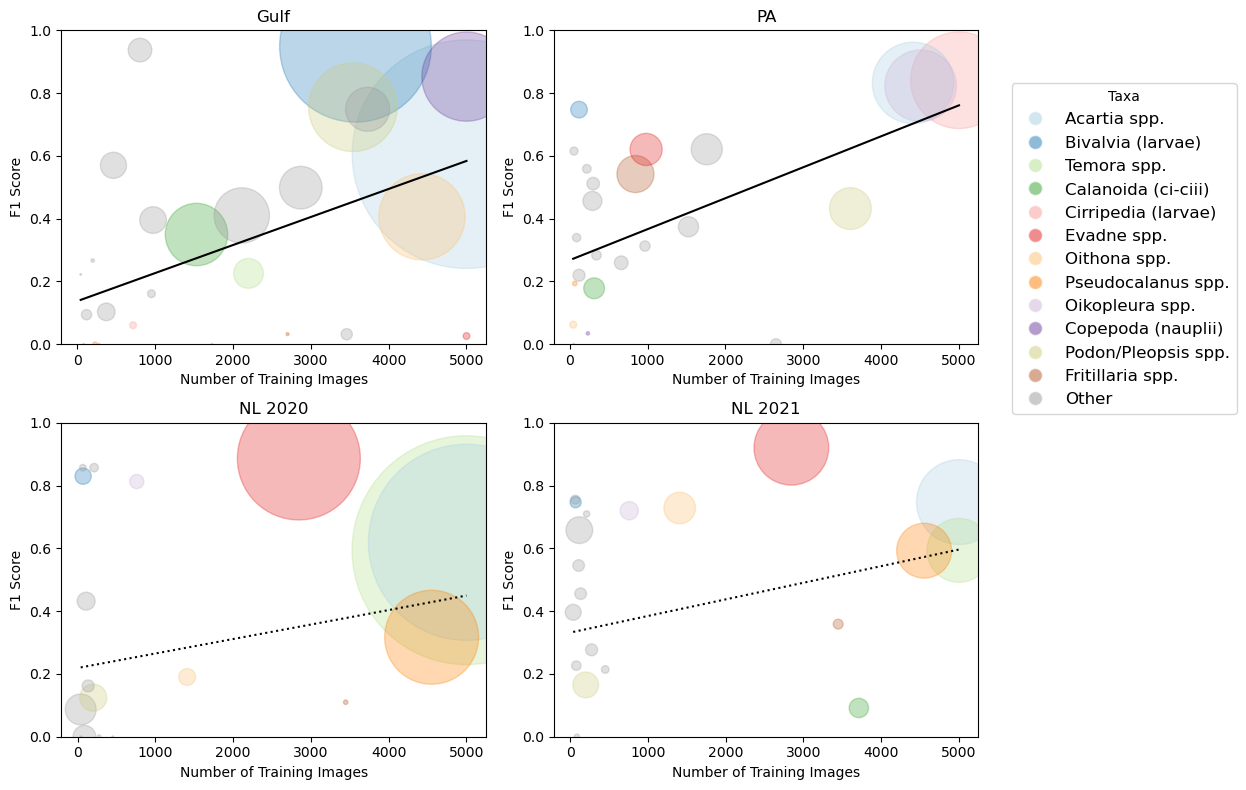

In [16]:
# bubble graphs for each dataset. Shows relationship between training image count and F1 scores for each taxa.
from matplotlib.lines import Line2D
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
type = 'f1-score'
for i, regionYear in enumerate(regions):
    row = i // 2  # Determine the row index
    col = i % 2   # Determine the column index
    ax = axes[row, col]  # Access the correct subplot
    presence_threshold = -1
    high_sup = f1_df[(f1_df['support'] > presence_threshold) & (f1_df['regionYear'] == regionYear)]
    score_types = ['precision', 'recall', 'f1-score']
    print('-------------------------------------------',regionYear, '------------------------------------')
    x = high_sup['regional_training']
    y = high_sup[type]
    # Calculate the line of best fit
    slope, intercept = np.polyfit(x, y, 1)  # Degree 1 for a linear fit
    x_ends = np.array([np.min(x), np.max(x)])
    line = slope * x_ends + intercept
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print(f" slope: {slope}, intercept: {intercept}, p_value: {p_value}, r_sq: {r_value**2}, std_err: {std_err}")
    ax.plot(x_ends, line, color='black', linestyle='-' if p_value < 0.05 else ':', label=f'Best Fit: y = {slope:.2f}x + {intercept:.2f}')
    ax.scatter(x, y, alpha=0.3, s=high_sup['support']*1.5, color=high_sup['color'])
    ax.set_title(f"{regionYear}")
    # if regionYear == 'Gulf':
    #     plt.xlim([0, 12000])
    # else:
    #     plt.xlim([0, 7000])
    ax.set_xlabel('Number of Training Images')
    ax.set_ylabel('F1 Score')
    ax.set_ylim([0, 1])
    # if regionYear == 'Gulf':
    #     ax.set_xlim([0, 13000])
    # Custom legend with specific labels and colors
legend_elements = [
    Line2D([0], [0], marker='o', color='w', alpha=0.5, markerfacecolor=colors[0], markersize=10, label=special_taxa[0]),
    Line2D([0], [0], marker='o', color='w', alpha=0.5, markerfacecolor=colors[1], markersize=10, label=special_taxa[1]),
    Line2D([0], [0], marker='o', color='w', alpha=0.5, markerfacecolor=colors[2], markersize=10, label=special_taxa[2]),
    Line2D([0], [0], marker='o', color='w', alpha=0.5, markerfacecolor=colors[3], markersize=10, label=special_taxa[3]),
    Line2D([0], [0], marker='o', color='w', alpha=0.5, markerfacecolor=colors[4], markersize=10, label=special_taxa[4]),
    Line2D([0], [0], marker='o', color='w', alpha=0.5, markerfacecolor=colors[5], markersize=10, label=special_taxa[5]),
    Line2D([0], [0], marker='o', color='w', alpha=0.5, markerfacecolor=colors[6], markersize=10, label=special_taxa[6]),
    Line2D([0], [0], marker='o', color='w', alpha=0.5, markerfacecolor=colors[7], markersize=10, label=special_taxa[7]),
    Line2D([0], [0], marker='o', color='w', alpha=0.5, markerfacecolor=colors[8], markersize=10, label=special_taxa[8]),
    Line2D([0], [0], marker='o', color='w', alpha=0.5, markerfacecolor=colors[9], markersize=10, label=special_taxa[9]),
    Line2D([0], [0], marker='o', color='w', alpha=0.5, markerfacecolor=colors[10], markersize=10, label=special_taxa[10]),
    Line2D([0], [0], marker='o', color='w', alpha=0.5, markerfacecolor=colors[11], markersize=10, label=special_taxa[11]),
    Line2D([0], [0], marker='o', color='w', alpha=0.5, markerfacecolor=colors[12], markersize=10, label=special_taxa[12]),
]
# Add the custom legend
fig.legend(handles=legend_elements, loc='upper right', fontsize=12, title="Taxa", bbox_to_anchor=(1.25, .9))
plt.tight_layout()
plt.show()
plt.close()




slope: 6.169074388336444e-05, intercept: 0.27655441577069245, p_value: 0.0024667078472083437, r_sq: 0.08553084519611764, std_err: 1.9875796592366375e-05


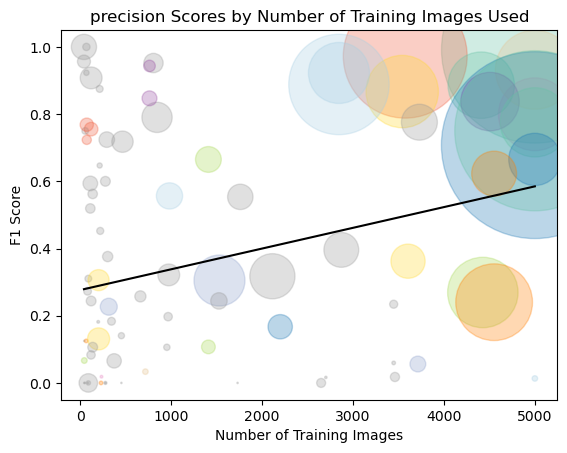

slope: 8.29893051738466e-05, intercept: 0.2928548346695812, p_value: 6.287686597505504e-06, r_sq: 0.1804435107976006, std_err: 1.7426987858940844e-05


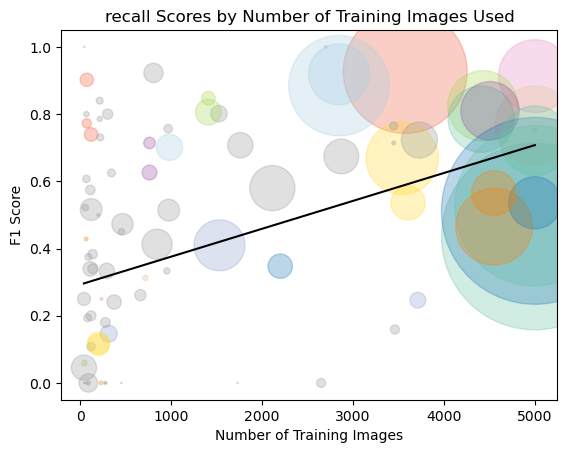

slope: 6.687597698485735e-05, intercept: 0.245510012378588, p_value: 0.00015010315975319728, r_sq: 0.1308107295192512, std_err: 1.6985839721405977e-05


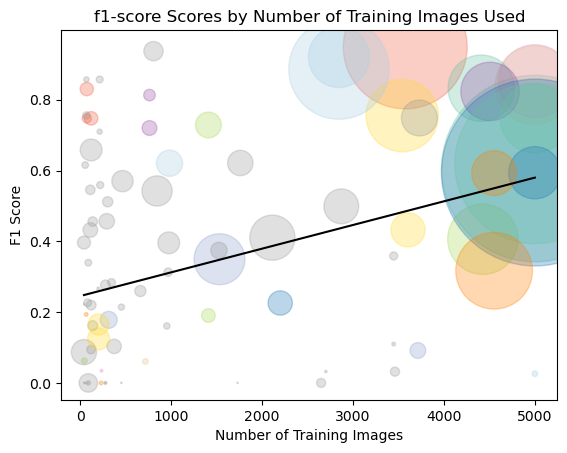

In [10]:
# bubble graphs for precision, recall, and F1 for each taxa average across all datasets.
high_sup = f1_df
for type in score_types:
    x = high_sup['regional_training']
    y = high_sup[type]
    # Calculate the line of best fit
    slope, intercept = np.polyfit(x, y, 1)  # Degree 1 for a linear fit
    x_ends = np.array([np.min(x), np.max(x)])
    line = slope * x_ends + intercept
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print(f"slope: {slope}, intercept: {intercept}, p_value: {p_value}, r_sq: {r_value**2}, std_err: {std_err}")
    plt.plot(x_ends, line, color='black', linestyle='-' if p_value < 0.05 else ':', label=f'Best Fit: y = {slope:.2f}x + {intercept:.2f}')
    plt.scatter(high_sup['regional_training'], high_sup[type], alpha=0.3, s=high_sup['support'], color=high_sup['color'])
    plt.title(f"{type} Scores by Number of Training Images Used")
    # if regionYear == 'Gulf':
    #     plt.xlim([0, 12000])
    # else:
    #     plt.xlim([0, 7000])
    plt.xlabel('Number of Training Images')
    plt.ylabel('F1 Score')
    plt.show()
    plt.close()

In [16]:
f1_df[f1_df['newName'] == 'Bivalvia (larvae)']

,newName,precision,recall,f1-score,support,regionYear,regional_training,color
1,Bivalvia (larvae),0.972435,0.926838,0.949089,7955,Gulf,3574.0,#f15f3f
41,Bivalvia (larvae),0.755319,0.739583,0.747368,96,PA,119.0,#f15f3f
68,Bivalvia (larvae),0.768519,0.902174,0.830000,92,NL 2020,71.0,#f15f3f
99,Bivalvia (larvae),0.723404,0.772727,0.747253,44,NL 2021,71.0,#f15f3f
